## Model (XGBoost)

We are going to use the XGBoost Model in order to predict whether the customers or not are going to go up to the end of the ideal journey, i.e. our target is going to be order ships.

* Libraries required

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Librarie for Preprocessing (By Us)
from utils import *

# Data Structures
from collections import defaultdict

# Model Libraries
from xgboost import XGBClassifier

# Import torch
import torch
import torch.nn as nn

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Optimización de hiperparámetros
import optuna

# Validación cruzada y particionado de datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from skopt import BayesSearchCV
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Retrieval

We retrieve the data from the original source, i.e. the one that is uncleaned and unprocessed. Also we retrive the event definition dataset:

In [2]:
data = pd.read_csv('../../1. Data/smaller_sample.csv')
event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

In [3]:
df = fingerhut_data_cleaner(data, event_defs)
df

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,milestone_number,journey_id,stage
0,278713037,1812321640,2,campaign_click,2021-05-31 06:00:00,1,0.0,1.0,Discover
1,278713037,1812321640,19,application_web_view,2021-05-31 23:11:03,2,0.0,1.0,Apply for Credit
2,278713037,1812321640,3,application_web_submit,2021-05-31 23:11:51,3,0.0,1.0,Apply for Credit
3,278713037,1812321640,19,application_web_view,2021-05-31 23:11:51,4,0.0,1.0,Apply for Credit
4,278713037,1812321640,19,application_web_view,2021-05-31 23:11:54,5,0.0,1.0,Apply for Credit
...,...,...,...,...,...,...,...,...,...
2849137,1948257044,1123823706,11,add_to_cart,2023-08-28 18:50:58,8,0.0,1.0,First Purchase
2849138,1948257044,1123823706,5,view_cart,2023-08-29 02:45:54,9,0.0,1.0,First Purchase
2849139,1948257044,1123823706,4,browse_products,2023-08-29 02:45:54,10,0.0,1.0,First Purchase
2849140,1948257044,1123823706,11,add_to_cart,2023-08-29 02:45:54,11,0.0,1.0,First Purchase


Then we call the **get_classification_dataset** function with *n_events = $5$* (this parameter could be changed everytime and depends only in the number of sequential events we would like to consider in the last **first_n_events** column). This takes approx **2:07** mins to run.

In [4]:
number_events_fixed = 20
col_name = 'first_' + str(number_events_fixed) +'_events'

df = get_classification_dataset(data, event_defs, n_events=number_events_fixed)
df.reindex(sorted(df.columns), axis=1)

,,account_activitation,approved_credit,average_length_seq,discover,downpayment_cleared,downpayment_received,first_20_events,first_purchase,has_pre_application,has_prospecting,...,max_journey,max_milestone,most_repeated_event,num_journeys,number_accounts,one_more_journey,order_ships,time_in_apply,time_in_discover,time_since_last_event
customer_id,,,,,,,,,,,,,,,,,,,,,,
5414,0,False,True,24.0,True,False,False,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...",False,False,True,...,27,1.0,4,1,1,False,False,549.0,4544216.0,"[0.0, 0.0, 549.0, 21051.0, 4544216.0, 2.0, 55...."
26746,0,False,True,3.0,True,False,False,"[2, 12, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",False,False,True,...,5,1.0,2,1,1,False,False,5990974.0,35426.0,"[0.0, 35426.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
43085,0,True,True,30.0,True,True,True,"[29, 2, 12, 4, 4, 4, 11, 4, 4, 11, 5, 6, 5, 5,...",True,False,False,...,30,6.0,5,1,1,False,True,414.0,16713.0,"[0.0, 21600.0, 16713.0, 414.0, 53.0, 10.0, 65...."
61659,0,False,True,7.0,True,False,False,"[12, 23, 4, 11, 6, 5, 4, 0, 0, 0, 0, 0, 0, 0, ...",False,False,False,...,7,1.0,4,1,1,False,False,16974.0,1030982.0,"[0.0, 16974.0, 1030982.0, 343254.0, 0.0, 0.0, ..."
67034,0,False,True,17.0,True,False,False,"[2, 19, 19, 19, 19, 3, 19, 12, 19, 4, 4, 11, 4...",False,False,True,...,22,1.0,19,1,1,False,False,506.0,8512.0,"[0.0, 8512.0, 111.0, 1.0, 17.0, 0.0, 1.0, 18.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147283220,0,False,True,11.0,True,False,False,"[12, 4, 4, 4, 4, 4, 4, 4, 4, 2, 21, 0, 0, 0, 0...",False,False,True,...,12,1.0,4,1,1,False,False,105.0,1620000.0,"[0.0, 105.0, 143.0, 88.0, 287.0, 189.0, 27.0, ..."
2147340717,0,False,True,8.0,False,False,False,"[12, 24, 4, 11, 5, 21, 21, 24, 0, 0, 0, 0, 0, ...",False,False,True,...,11,1.0,21,1,1,False,False,74557.0,0.0,"[0.0, 0.0, 164456.0, 21.0, 31.0, 0.0, 0.0, 0.0..."
2147417277,0,False,True,13.0,False,False,False,"[12, 6, 11, 5, 4, 19, 3, 6, 11, 5, 4, 19, 3, 0...",False,False,False,...,15,1.0,3,1,1,False,False,23968.0,0.0,"[0.0, 20977.0, 0.0, 0.0, 0.0, 441.0, 0.0, 2991..."


In [5]:
cust_ids = df.index
cust_ids = [x[0] for x in cust_ids]
df.reset_index(drop=True, inplace=True)
df['customer_id'] = cust_ids
df.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,first_purchase,account_activitation,...,order_ships,max_milestone,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event,customer_id
0,1,27,True,1,False,4,24.0,True,False,False,...,False,1.0,True,False,2,4544216.0,549.0,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...","[0.0, 0.0, 549.0, 21051.0, 4544216.0, 2.0, 55....",5414
1,1,5,True,1,False,2,3.0,True,False,False,...,False,1.0,True,False,2,35426.0,5990974.0,"[2, 12, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.0, 35426.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",26746
2,1,30,True,1,False,5,30.0,True,True,True,...,True,6.0,False,False,2,16713.0,414.0,"[29, 2, 12, 4, 4, 4, 11, 4, 4, 11, 5, 6, 5, 5,...","[0.0, 21600.0, 16713.0, 414.0, 53.0, 10.0, 65....",43085
3,1,7,True,1,False,4,7.0,True,False,False,...,False,1.0,False,False,2,1030982.0,16974.0,"[12, 23, 4, 11, 6, 5, 4, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 16974.0, 1030982.0, 343254.0, 0.0, 0.0, ...",61659
4,1,22,True,1,False,19,17.0,True,False,False,...,False,1.0,True,False,2,8512.0,506.0,"[2, 19, 19, 19, 19, 3, 19, 12, 19, 4, 4, 11, 4...","[0.0, 8512.0, 111.0, 1.0, 17.0, 0.0, 1.0, 18.0...",67034


### Selecting the customers with a certain amount of events -- NO LONGER NEEDED AS ALL HAVE EXACTLY THE SAME AMOUNT OF EVENTS

We select the customers with certain fixed amount of events 

In [6]:
# number_events_fixed = 20

# col_name = 'first_' + str(number_events_fixed) +'_events'

# lengths = df[col_name].apply(lambda x: len(x))
# print(lengths.value_counts())

In [7]:
# idxs = lengths[lengths == number_events_fixed].index
# df_selected = df.loc[idxs]

### New dataset without the following columns:

* First 5 events
* max_milestone
* downpayment_cleared
* first_purchase
* downpayment_received
* account_activitation

We are going to drop the next columns because they give information for the outcome of the target variable and therefore they are not going to be used in the model because we want to predict in an early stage of the journey if the customer is going to go up to the end of the journey.

In [8]:
df.drop(columns=['max_milestone', 'downpayment_cleared', 'first_purchase', 'downpayment_received', 'account_activitation', 'customer_id'], inplace=True)
df

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,1,27,True,1,False,4,24.0,True,False,True,False,2,4544216.0,549.0,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...","[0.0, 0.0, 549.0, 21051.0, 4544216.0, 2.0, 55...."
1,1,5,True,1,False,2,3.0,True,False,True,False,2,35426.0,5990974.0,"[2, 12, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.0, 35426.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,1,30,True,1,False,5,30.0,True,True,False,False,2,16713.0,414.0,"[29, 2, 12, 4, 4, 4, 11, 4, 4, 11, 5, 6, 5, 5,...","[0.0, 21600.0, 16713.0, 414.0, 53.0, 10.0, 65...."
3,1,7,True,1,False,4,7.0,True,False,False,False,2,1030982.0,16974.0,"[12, 23, 4, 11, 6, 5, 4, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 16974.0, 1030982.0, 343254.0, 0.0, 0.0, ..."
4,1,22,True,1,False,19,17.0,True,False,True,False,2,8512.0,506.0,"[2, 19, 19, 19, 19, 3, 19, 12, 19, 4, 4, 11, 4...","[0.0, 8512.0, 111.0, 1.0, 17.0, 0.0, 1.0, 18.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83277,1,12,True,1,False,4,11.0,True,False,True,False,2,1620000.0,105.0,"[12, 4, 4, 4, 4, 4, 4, 4, 4, 2, 21, 0, 0, 0, 0...","[0.0, 105.0, 143.0, 88.0, 287.0, 189.0, 27.0, ..."
83278,1,11,False,1,False,21,8.0,True,False,True,False,2,0.0,74557.0,"[12, 24, 4, 11, 5, 21, 21, 24, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 164456.0, 21.0, 31.0, 0.0, 0.0, 0.0..."
83279,1,15,False,1,False,3,13.0,True,False,False,False,2,0.0,23968.0,"[12, 6, 11, 5, 4, 19, 3, 6, 11, 5, 4, 19, 3, 0...","[0.0, 20977.0, 0.0, 0.0, 0.0, 441.0, 0.0, 2991..."
83280,1,32,False,1,False,4,27.0,True,False,True,False,2,0.0,269.0,"[4, 4, 4, 4, 4, 4, 3, 3, 3, 12, 4, 4, 4, 4, 4,...","[0.0, 23.0, 499101.0, 27.0, 46.0, 202.0, 74.0,..."


### Changing the boolean columns to 0 and 1

In [9]:
# Setting float values for all the columns except the last 2
df = df.astype({col: 'float' for col in df.columns[:-2]})
df.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,1.0,27.0,1.0,1.0,0.0,4.0,24.0,1.0,0.0,1.0,0.0,2.0,4544216.0,549.0,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...","[0.0, 0.0, 549.0, 21051.0, 4544216.0, 2.0, 55...."
1,1.0,5.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,1.0,0.0,2.0,35426.0,5990974.0,"[2, 12, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.0, 35426.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,1.0,30.0,1.0,1.0,0.0,5.0,30.0,1.0,1.0,0.0,0.0,2.0,16713.0,414.0,"[29, 2, 12, 4, 4, 4, 11, 4, 4, 11, 5, 6, 5, 5,...","[0.0, 21600.0, 16713.0, 414.0, 53.0, 10.0, 65...."
3,1.0,7.0,1.0,1.0,0.0,4.0,7.0,1.0,0.0,0.0,0.0,2.0,1030982.0,16974.0,"[12, 23, 4, 11, 6, 5, 4, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 16974.0, 1030982.0, 343254.0, 0.0, 0.0, ..."
4,1.0,22.0,1.0,1.0,0.0,19.0,17.0,1.0,0.0,1.0,0.0,2.0,8512.0,506.0,"[2, 19, 19, 19, 19, 3, 19, 12, 19, 4, 4, 11, 4...","[0.0, 8512.0, 111.0, 1.0, 17.0, 0.0, 1.0, 18.0..."


### Embedding for the sequential events and for the times

We are going to capture the information of the sequential events in the first 5 events by transforming this sequence into a vector. As this column contains arrays of the fixed specified length, we cannot parse it directly to our model.

#### Function

In [10]:
class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#### Embedding the events

In [11]:
# Embed event id sequence into smaller dimension
event_id = df[col_name]
event_id = torch.tensor(event_id.to_list()).float()
emb = Embedding(5, number_events_fixed)
event_id = emb(event_id)

/var/folders/8l/f787_tgj7sg6grwn27dvfx0h0000gn/T/ipykernel_25800/3543841415.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/torch/csrc/utils/tensor_new.cpp:278.)
  event_id = torch.tensor(event_id.to_list()).float()


#### Embedding the times

In [12]:
# Embed event id sequence into smaller dimension
times = df['time_since_last_event']
times = torch.tensor(times.to_list()).float()
emb_t = Embedding(5, number_events_fixed)
times = emb(times)

In [13]:
event_id_df = pd.DataFrame(event_id.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])
times_df = pd.DataFrame(times.detach().numpy(), columns=[f'time_{i}' for i in range(5)])

df.drop(columns=[col_name, 'time_since_last_event'], inplace=True)
df.reset_index(drop=True, inplace=True)

new_dfx = pd.concat([df, event_id_df, times_df], axis=1)
new_dfx.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,...,event_id_0,event_id_1,event_id_2,event_id_3,event_id_4,time_0,time_1,time_2,time_3,time_4
0,1.0,27.0,1.0,1.0,0.0,4.0,24.0,1.0,0.0,1.0,...,1.379312,-0.104741,0.578822,0.915176,0.488270,-131084.890625,-18791.021484,-138090.921875,-161141.140625,-53334.417969
1,1.0,5.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,1.0,...,0.664583,0.928158,-0.229372,1.239874,1.322270,888.643738,1697.033081,1182.472290,3313.512207,2466.733154
2,1.0,30.0,1.0,1.0,0.0,5.0,30.0,1.0,1.0,0.0,...,1.073141,-1.276163,-0.071933,0.272088,0.046549,887.773254,1239.866089,-306.402863,1656.266113,1766.334106
3,1.0,7.0,1.0,1.0,0.0,4.0,7.0,1.0,0.0,0.0,...,2.109451,1.346191,0.803371,2.301213,1.810838,20723.341797,28942.261719,-7152.378906,38662.312500,41231.632812
4,1.0,22.0,1.0,1.0,0.0,19.0,17.0,1.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,224.840042,421.519043,345.401062,854.255981,612.778198


In [14]:
new_dfx['order_ships'].value_counts()

order_ships
0.0    67144
1.0    16138
Name: count, dtype: int64

In [15]:
# # Downsample majority class
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = new_dfx[new_dfx['order_ships'] == 0]

df_minority = new_dfx[new_dfx['order_ships'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=16138,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['order_ships'].value_counts()

order_ships
0.0    16138
1.0    16138
Name: count, dtype: int64

In [16]:
# # Upsample minority class
# df_majority = new_dfx[new_dfx['order_ships'] == 0]
# df_minority = new_dfx[new_dfx['order_ships'] == 1]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=67144,    # to match majority class
#                                  random_state=123) # reproducible results

# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# # Display new class counts
# df_upsampled['order_ships'].value_counts()

### Separating the data and the target

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [18]:
df_final = df_downsampled

In [19]:
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

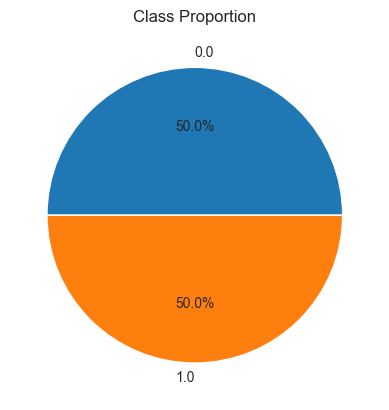

In [20]:
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion')
plt.show()

In [21]:
df_final['order_ships'].value_counts()

order_ships
0.0    16138
1.0    16138
Name: count, dtype: int64

## XGBoost Model

We can see that the class proportion is not balanced, but we are going to use the **scale_pos_weight** parameter in the XGBoost model in order to balance the classes. One quick rule of thumb to consider is that the scale_pos_weight should be equal to the ratio of the number of negative class to the positive class.

$$scale\_pos\_weight = \frac{negatives}{positives}$$

and therefore:

$$scale\_pos\_weight = \frac{negatives}{positives} = \frac{54339}{16093} = 3.3765612378$$

### Hyperparameter Fine-Tuning Function For XGBoost

The next function is going to be used in order to fine-tune the hyperparameters of the XGBoost model by employing a strategy called Tree-structured Parzen Estimator (TPE). The TPE algorithm is a Bayesian optimization algorithm that explores the hyperparameter space efficiently.

In [22]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = f1_score(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

### Simple Train-Test Split

In [23]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

# Hyperparameter space
options = {'max_depth': hp.quniform('max_depth', 1, 20, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 10),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'random_state': 2024,
           'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   early_stopping_rounds=50),
            space=options,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            ) #timeout=60*5 # 5 minutos de tiempo de ejecución

best

100%|██████████| 50/50 [01:29<00:00,  1.80s/trial, best loss: -0.854483282674772] 


{'colsample_bytree': 0.7993536825357457,
 'gamma': 0.027303726971080935,
 'learning_rate': 0.2816257378566173,
 'max_depth': 9.0,
 'min_child_weight': 20.357562546819675,
 'reg_alpha': 5.920496259778862,
 'reg_lambda': 2.93044739840992,
 'scale_pos_weight': 1.3365265739529026,
 'subsample': 0.7296501211291883}

In [24]:
best['max_depth'] = int(best['max_depth'])

In [25]:
# Train the model
xgb = XGBClassifier(**best, n_estimators=500)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

Metrics : 
              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82      4810
         1.0       0.80      0.88      0.84      4873

    accuracy                           0.83      9683
   macro avg       0.83      0.83      0.83      9683
weighted avg       0.83      0.83      0.83      9683



<Axes: >

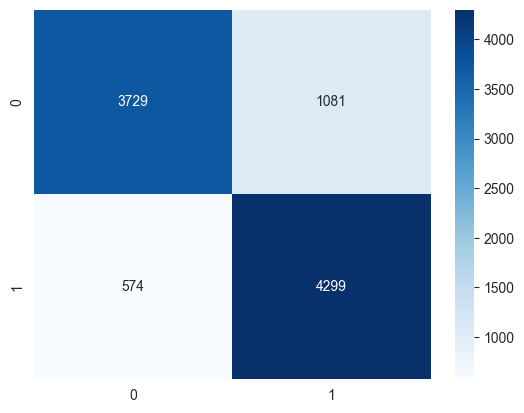

In [26]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

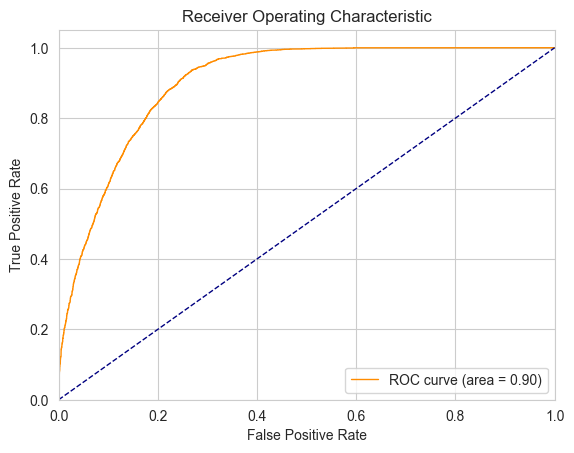

In [27]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Most Important Features

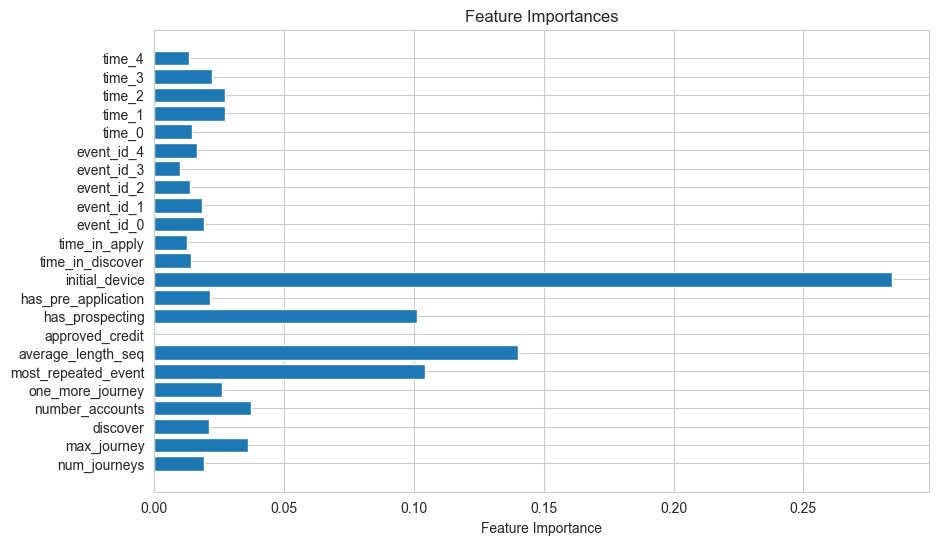

In [28]:
# Train the model
xgb = XGBClassifier(**best,
                    random_state=2024)
xgb.fit(X,y)

# Columns
x = list(df_final.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [29]:
in_dev = df_downsampled['initial_device']
target = df_downsampled['order_ships']

# Make a cross product of the two columns and count the frequency of each pair
cross = pd.crosstab(in_dev, target)
cross

order_ships,0.0,1.0
initial_device,,
1.0,329,406
2.0,15601,14338
3.0,201,1391


### Cross Validation

In [30]:
# Model
xgb = XGBClassifier(**best, n_estimators=500)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='f1')

print('Mean F1 score : ', scores.mean())
print('Std F1 : ', scores.std())

Mean F1 score :  0.8405468265491267
Std F1 :  0.002616107235636539
